In [1]:
import numpy as np
import pandas as pd

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.rule_based_controller import RuleBasedController

## Load one month of 15-min data

In [2]:
df, price_series, timestamps = load_price_data(
    csv_path   = "../data/raw/dayahead_2024_11.csv",
    resolution = "15min",
)

df_week = df.loc["2024-11-08":"2024-11-14"] # 672 steps (1 week)
price_week = df_week["Day Ahead Auktion"].values.astype(np.float32)
timestamps_week = df_week.index

print(len(price_week), "time steps in a week (should be 672)")
print("Week from", timestamps_week[0], "to", timestamps_week[-1])

672 time steps in a week (should be 672)
Week from 2024-11-08 00:00:00+01:00 to 2024-11-14 23:45:00+01:00


## 1. Environment for *discrete* actions

In [3]:
env_disc = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,              # 15-minute time step
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,
    random_seed=42,
)

## 1-week rollout with *discrete* actions

Episode finished early at step 671


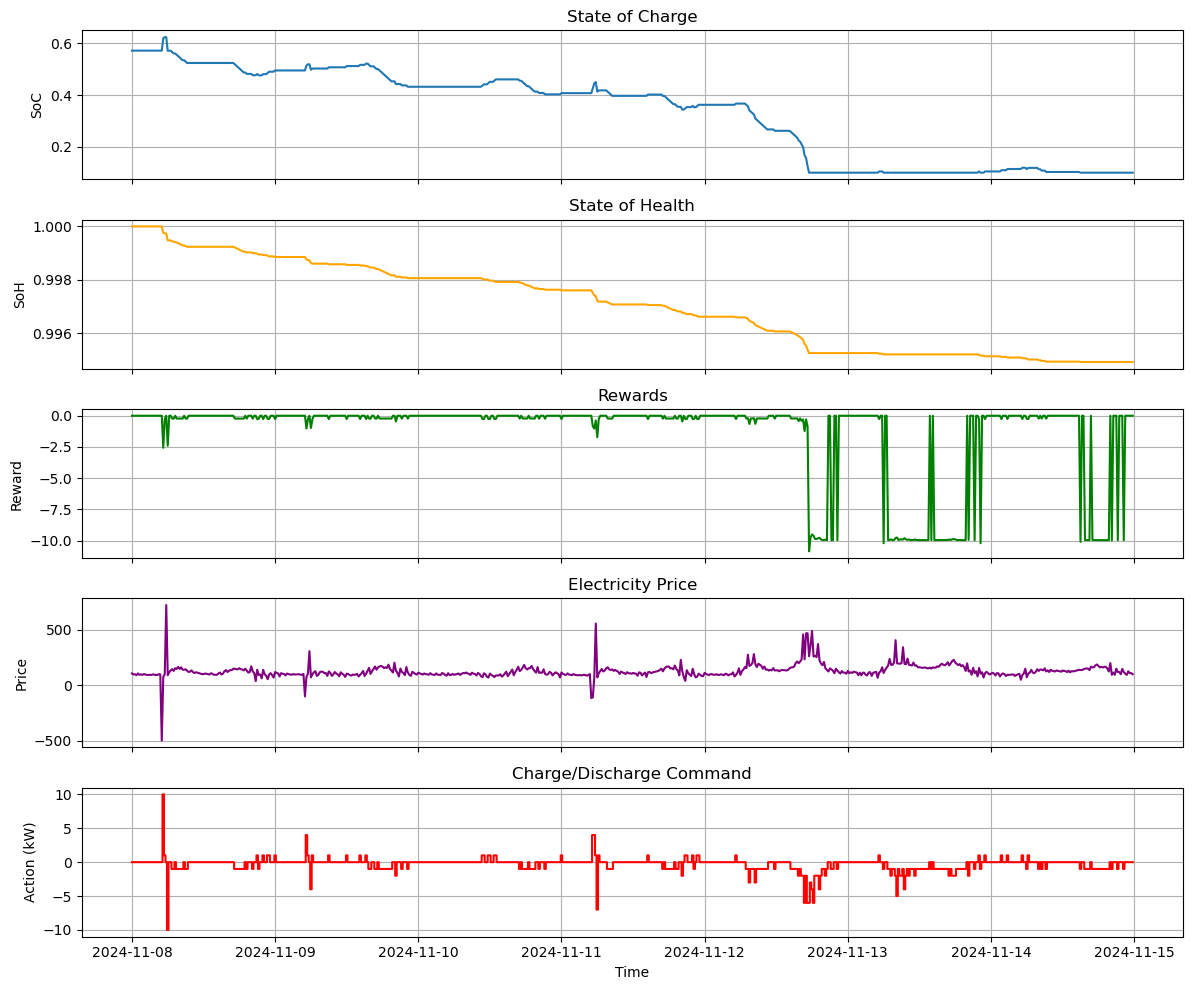

In [4]:
rb_controller_disc = RuleBasedController(env_disc) # Instantiate Rule Based Controller

obs, info = env_disc.reset()

soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_kW = []

n_steps = len(price_week)   # run full week (672 steps)

for t in range(n_steps):
    # Controller decides action index (0..20)
    action_idx = rb_controller_disc.act(obs)

    # Environment step
    obs, reward, terminated, truncated, info = env_disc.step(action_idx)

    # Store values
    soc_list.append(obs[0])
    soh_list.append(obs[1])
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_list_kW.append(env_disc.discrete_action_values[action_idx])

    if terminated or truncated:
        print(f"Episode finished early at step {t}")
        break

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_kW,
    timestamps=timestamps_week[:len(soc_list)],
)

## 2. Environment for *continuous* actions

In [5]:
env_cont = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,              # 15-minute steps
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,
    random_seed=42,
)

## 1-week rollout with *continuous* actions

Episode finished at step 671


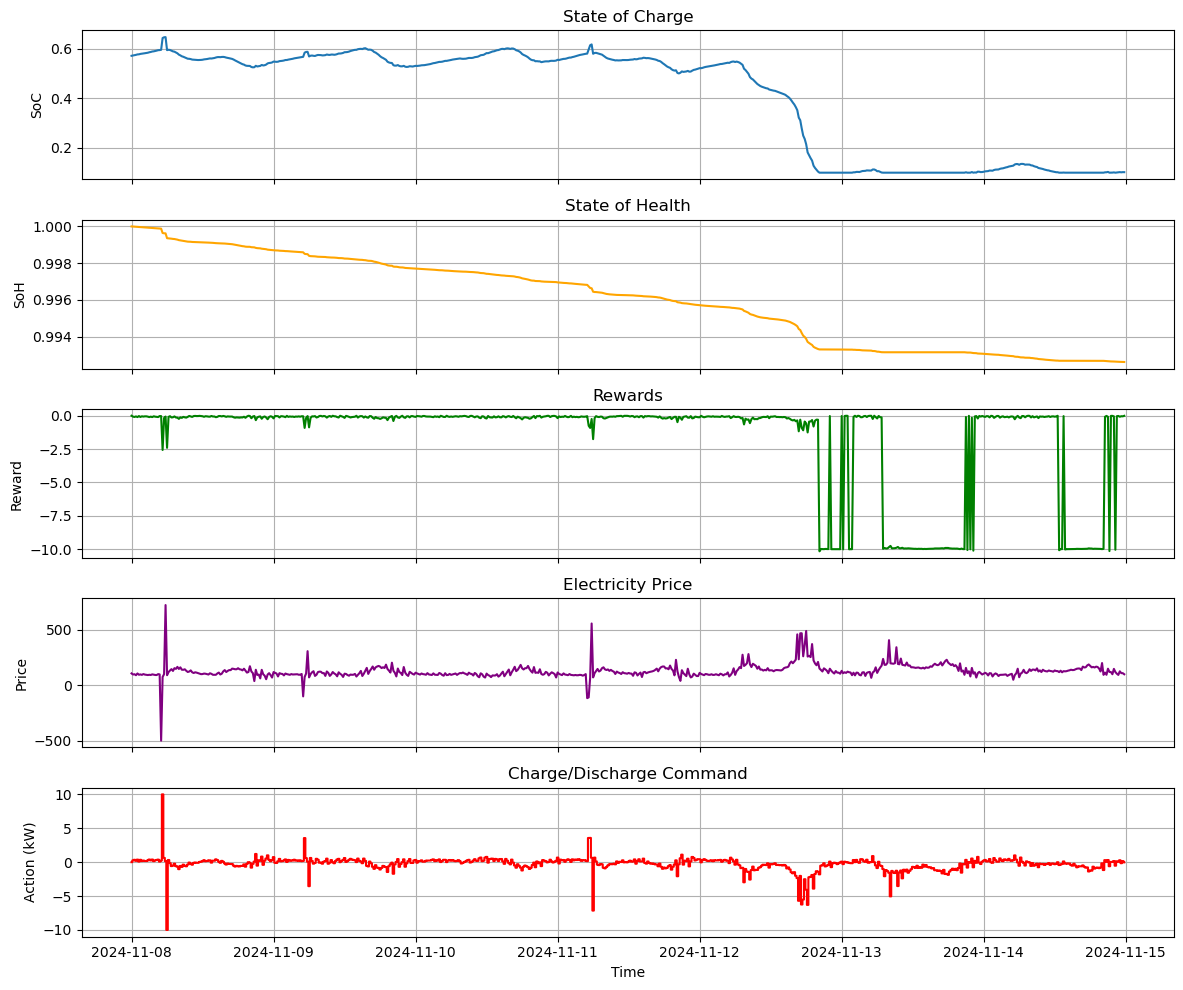

In [6]:
rb_controller_cont = RuleBasedController(env_cont) # Instantiate Rule Based Controller

obs, info = env_cont.reset()

soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_cont = []

n_steps = len(price_week)   # 672 steps

for t in range(n_steps):
    action = rb_controller_cont.act(obs)

    obs, reward, terminated, truncated, info = env_cont.step(action)

    soc_list.append(obs[0])
    soh_list.append(obs[1])
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_list_cont.append(float(action[0]))  # store kW command as float

    if terminated or truncated:
        print(f"Episode finished at step {t}")
        break

#action_list_cont[:20]

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_cont,
    timestamps=timestamps_week[:len(soc_list)],
)